## <span style="color:#a4d4a3">**Grid Maps**</span>

We have talked about the <span style="color:#ffa500">**Kalman Filter**</span>, the <span style="color:#ffa500">**Extended Kalman Filter**</span> and briefly mentioned some alternatives. 
Now we will talk about <span style="color:#ffa500">**Particle Filters**</span>.  

Before we dive into that, we will introduce <span style="color:#ffa500">**grid maps**</span> that can be used instead of the <span style="color:#ffa500">**features/landmarks**</span> we saw in KF approaches.

So, in this module, we will talk about <span style="color:#ffa500">**grid maps**</span>, how to use the Particle Filter to <span style="color:#ffa500">**localize**</span> in a grid map and then we will go to the full <span style="color:#ffa500">**Particle Filter SLAM**</span>.

---


### ⚔️ <span style="color:#a4d4a3">**Feature-based vs. Occupancy-based Mapping**</span>

- In order to do <span style="color:#ffa500">**feature/landmark-based SLAM**</span> we need a way to identify features from our sensor feed (camera, LiDAR, etc.) typically part of the <span style="color:#ffa500">**front-end**</span>.
- <span style="color:#ffa500">**Occupancy maps**</span> can be derived <span style="color:#ffa500">**directly**</span> from the sensor measurements (typically LiDARs) with no additional processing.


##### 📌 <span style="color:#a4d4a3">Features/landmarks:</span>
- <span style="color:#ffa500">**Natural choice**</span> for Kalman Filter–based SLAM systems.  
- <span style="color:#ffa500">**Compact**</span> representation.  
- Multiple feature observations <span style="color:#ffa500">**improve**</span> the landmark <span style="color:#ffa500">**position estimate**</span> (EKF).  
- Not having a <span style="color:#ffa500">**reliable feature detector**</span> is a problem.

##### 𝄜 <span style="color:#a4d4a3">Grid Maps:</span>
- Discretize the world into <span style="color:#ffa500">**cells**</span>.  
- Grid structure is <span style="color:#ffa500">**rigid**</span>.  
- Each cell is assumed to be <span style="color:#ffa500">**occupied**</span> or <span style="color:#ffa500">**free**</span>.  
- <span style="color:#ffa500">**Non-parametric**</span> model.  
- Large maps require <span style="color:#ffa500">**substantial memory resources**</span>.  
- Do <span style="color:#ffa500">**not rely**</span> on a feature detector.

---


### 🤔 <span style="color:#a4d4a3">**Assumptions**</span>

Each cell <span style="color:#ffa500">**$m_i$**</span> is a <span style="color:#ffa500">**binary random variable**</span> that models the occupancy.  
- **Occupied:** $\quad p(m_i) \to 1$  
- **Free space:** $\quad p(m_i) \to 0$  
- **No knowledge:** $\quad p(m_i) = 0.5$

<p align="center">
  <img src="../figures/grid_example.png" alt="Robot Odometry" width="520"/>
</p>

 <span style="color:#00703c">**Assumption 1 —</span> Binary cell state:** The area that corresponds to a cell is either <span style="color:#ffa500">**completely free or occupied**</span>.

 <span style="color:#00703c">**Assumption 2 —</span> Static world:** The world is <span style="color:#ffa500">**static**</span> (either free or occupied and does not change).

 <span style="color:#00703c">**Assumption 3 —</span> Cell independence:** The cells (the random variables) are <span style="color:#ffa500">**independent**</span> of each other.

> 📝 <span style="color:#0098ff">**Note:**</span> <em>**Assumption 3 — Cell independence**, is a convenient approximation, not a faithful property of real environments. In reality, occupancy is spatially correlated, neighboring cells along the same surface (e.g., a wall) tend to share the same state. We assume independence to keep updates factorized and online (one Bayes/log-odds update per cell). More expressive models add spatial coupling, which can improve consistency but at the cost of higher compute/memory and more complex inference.</em>

### 🔍 <span style="color:#a4d4a3">**Representation**</span>

The <span style="color:#ffa500">**probability distribution**</span> of the map is given by the <span style="color:#ffa500">**product over the cells**</span>,

$$
p(m) \;=\; \prod_i p(m_i).
$$

Given <span style="color:#ffa500">**sensor data**</span> $z_{1:t}$ and the <span style="color:#ffa500">**poses**</span> $x_{1:t}$, estimate the <span style="color:#ffa500">**map**</span>:

$$
p\!\left(m \mid z_{1:t}, x_{1:t}\right) \;=\; \prod_i p\!\left(m_i \mid z_{1:t}, x_{1:t}\right),
$$

where $m_i$ is a <span style="color:#ffa500">**binary random variable**</span>.

We can use the <span style="color:#ffa500">**Bayes Filter**</span> to estimate the map. Now it’s simpler since we don’t need the <span style="color:#ffa500">**prediction**</span> step since the world is <span style="color:#ffa500">**static**</span>  

$\quad\quad$ **↳** **Binary Bayes Filter (static state)**.


#### <span style="color:#a4d4a3">**Static-State Binary Bayes Filter** (Mathematical Derivation)</span>

Starting with the probability distribuiton of the map, we apply <span style="color:#ffa500">**Bayes' rule**</span>:

$$
\begin{aligned}
p(m_i \mid z_{1:t}, x_{1:t}) = \frac{p(z_t \mid m_i, z_{1:t-1}, x_{1:t}) \cdot p(m_i \mid z_{1:t-1}, x_{1:t})}{p(z_t \mid z_{1:t-1}, x_{1:t})} \quad\quad (1)
\end{aligned}
$$

<details>

<summary>📝 <strong><span style="color:#e74c3c">Note:</span> </strong> <em> How did we apply Bayes' Rule? </em> </summary>

- <span style="color:#ffa500">**Bayes' Rule**</span> for multiple events involved, is given by:  

$$
p(A \mid B, C) = \frac{p(B \mid A, C) \cdot p(A \mid C)}{p(B \mid C)}
$$

- We assume known states $x_{1:t}$ and thus we condition on the states as known events.

- The previous observations $z_{1:t-1}$ are also known (fixed events), as they represent past sensor measurements.

- Therefore, we explicitly include both in our posterior probability:  

  $$
  p(m_i \mid z_t, z_{1:t-1}, x_{1:t})
  $$  

- By setting our events as follows:  
  - $A = m_i$ (current state),  
  - $B = z_t$ (current measurement),  
  - $C = z_{1:t-1}, x_{1:t}$ (fixed past measurements and known states),  

  we have:  
  $$
  p(m_i \mid z_t, z_{1:t-1}, x_{1:t}) = \frac{p(z_t \mid m_i, z_{1:t-1}, x_{1:t}) \cdot p(m_i \mid z_{1:t-1}, x_{1:t})}{p(z_t \mid z_{1:t-1}, x_{1:t})}
  $$

This expression shows explicitly how we integrate new observations $z_t$ into our previous belief (prediction), resulting in an updated posterior belief of the current map cell $m_i$.

</details>

Then we make some standard <span style="color:#ffa500">**Markov assumptions**</span>:
- Knowing where the robot is in the future does not provide additional information: $\:\: p(m_i \mid z_{1:t-1}, x_{1:t}) \to p(m_i \mid z_{1:t-1}, x_{1:t-1})$
- If we know the state of the cell, we can get rid of the past observations: $\:\: p(z_t \mid m_i, z_{1:t-1}, x_{1:t}) \to p(z_t \mid m_i, x_{1:t})$

Thus Eq. (1) becomes:

$$
\begin{aligned}
p(m_i \mid z_{1:t}, x_{1:t}) &= \frac{p(z_t \mid m_i, z_{1:t-1}, x_{1:t}) \cdot p(m_i \mid z_{1:t-1}, x_{1:t})}{p(z_t \mid z_{1:t-1}, x_{1:t})} \\
&= \frac{p(z_t \mid m_i, x_{1:t}) \cdot p(m_i \mid z_{1:t-1}, x_{1:t-1})}{p(z_t \mid z_{1:t-1}, x_{1:t})} \quad\quad (2)
\end{aligned}
$$

We can apply <span style="color:#ffa500">**Bayes' rule**</span> again to $\:\: p(z_t \mid m_i, x_t)$:

$$
p(z_t \mid m_i, x_t) = \frac{p(m_i \mid z_t, x_t) \cdot p(z_t \mid x_t)}{p(m_i \mid x_t)} \quad\quad (3)
$$

Then form Eq. (2) and (3):

$$
\begin{aligned}
p(m_i \mid z_{1:t}, x_{1:t}) &= \frac{p(z_t \mid m_i, z_{1:t-1}, x_{1:t}) \cdot p(m_i \mid z_{1:t-1}, x_{1:t})}{p(z_t \mid z_{1:t-1}, x_{1:t})} \\
&= \frac{p(z_t \mid m_i, x_{1:t}) \cdot p(m_i \mid z_{1:t-1}, x_{1:t-1})}{}  \\
&= \frac{p(m_i \mid z_t, x_t) \cdot p(z_t \mid x_t) \cdot p(m_i \mid z_{1:t-1}, x_{1:t-1}) }{p(z_t \mid z_{1:t-1}, x_{1:t}) \cdot p(m_i \mid x_t)} \quad\quad (4)
\end{aligned}
$$

Another <span style="color:#ffa500">**Markov assumption**</span>:
- Since there is no observation, the state $x_t$ does not help us alone: $\:\: p(m_i \mid x_t) \to p(m_i)$

Continuing from Eq. (4):

$$
\begin{aligned}
p(m_i \mid z_{1:t}, x_{1:t}) &= \frac{p(z_t \mid m_i, z_{1:t-1}, x_{1:t}) \cdot p(m_i \mid z_{1:t-1}, x_{1:t})}{p(z_t \mid z_{1:t-1}, x_{1:t})} \\
&= \frac{p(z_t \mid m_i, x_{1:t}) \cdot p(m_i \mid z_{1:t-1}, x_{1:t-1})}{}  \\
&= \frac{p(m_i \mid z_t, x_t) \cdot p(z_t \mid x_t) \cdot p(m_i \mid z_{1:t-1}, x_{1:t-1}) }{p(z_t \mid z_{1:t-1}, x_{1:t}) \cdot p(m_i \mid x_t)} \\
&= \frac{p(m_i \mid z_t, x_t) \cdot p(z_t \mid x_t) \cdot p(m_i \mid z_{1:t-1}, x_{1:t-1}) }{p(m_i) \cdot p(z_t \mid z_{1:t-1}, x_{1:t})} \quad\quad (5)
\end{aligned}
$$

Leveraging our <span style="color:#ffa500">**first assumption**</span>, that we have <span style="color:#ffa500">**binary cell states**</span>, we can do exactly the same for the opposite event:

$$
\begin{aligned}
p(\neg m_i \mid z_{1:t}, x_{1:t}) &= \frac{p(\neg m_i \mid z_t, x_t) \cdot p(z_t \mid x_t) \cdot p(\neg m_i \mid z_{1:t-1}, x_{1:t-1}) }{p(\neg m_i) \cdot p(z_t \mid z_{1:t-1}, x_{1:t})} \quad\quad (6)
\end{aligned}
$$

By computing the <span style="color:#ffa500">**ratio of both probabilities**</span>, Eq. (5) and (6), we obtain:

$$
\begin{aligned}
\frac{p(m_i \mid z_{1:t}, x_{1:t})}{p(\neg m_i \mid z_{1:t}, x_{1:t})} &= \frac{\frac{p(m_i \mid z_t, x_t) \cdot \cancel{p(z_t \mid x_t)} \cdot p(m_i \mid z_{1:t-1}, x_{1:t-1}) }{p(m_i) \cdot \cancel{p(z_t \mid z_{1:t-1}, x_{1:t})}}}{\frac{p(\neg m_i \mid z_t, x_t) \cdot \cancel{p(z_t \mid x_t)} \cdot p(\neg m_i \mid z_{1:t-1}, x_{1:t-1}) }{p(\neg m_i) \cdot \cancel{p(z_t \mid z_{1:t-1}, x_{1:t})}}} \\
&= \frac{p(m_i \mid z_t, x_t) \cdot p(m_i \mid z_{1:t-1}, x_{1:t-1})}{p(\neg m_i \mid z_t, x_t) \cdot p(\neg m_i \mid z_{1:t-1}, x_{1:t-1})} \cdot \frac{p(\neg m_i)}{p(m_i)} \\
&= \underbrace{\frac{p(m_i \mid z_t, x_t)}{1 - p(m_i \mid z_t, x_t)}}_{\text{uses }z_t} \cdot \underbrace{\frac{p(m_i \mid z_{1:t-1}, x_{1:t-1})}{1 - p(m_i \mid z_{1:t-1}, x_{1:t-1})}}_{\text{recursive term}} \cdot \underbrace{\frac{1 - p(m_i)}{p(m_i)}}_{\text{prior}}
\end{aligned}
$$

By inspecting the terms we see that we have:
- a term that uses only the <span style="color:#ffa500">**current obseravtion**</span> $z_t$.
- a <span style="color:#ffa500">**recursive term**</span> that uses the past information.
- a term that is my <span style="color:#ffa500">**prior**</span> knowledge.

##### <span style="color:#a4d4a3"> **From Ration to Probability** </span>

We can turn the ratio into the probability:

$$
p(m_i \mid z_{1:t}, x_{1:t}) = \left[ 1 + \frac{1 - p(m_i \mid z_t, x_t)}{p(m_i \mid z_t, x_t)} \cdot \frac{1 - p(m_i \mid z_{1:t-1}, x_{1:t-1})}{p(m_i \mid z_{1:t-1}, x_{1:t-1})} \cdot \frac{p(m_i)}{1 - p(m_i)} \right]^{-1}
$$

<details>

<summary>📝 <strong><span style="color:#e74c3c">Note:</span> </strong> <em> Wait... How did you do that? </em> </summary>

From the following:

$$
\begin{aligned}
\frac{p(x)}{1 - p(x)} &= Y \\
p(x) &= Y - Y \cdot p(x) \\
p(x) \cdot (1 + Y) &= Y \\
p(x) &= \frac{Y}{1+Y} \\
p(x) &= \frac{1}{1 + \frac{1}{Y}} \\
p(x) &= (1 + Y^{-1})^{-1}
\end{aligned}
$$

</details>

For reasons of <span style="color:#ffa500">**efficiency**</span>, we perform the calculations in the <span style="color:#ffa500">**log odds notation**</span>!

##### <span style="color:#a4d4a3"> **Log-Odds Notation** </span>

Define the <span style="color:#ffa500">**log-odds ratio**</span> as:

$$
l(x) = \log\frac{p(x)}{1 - p(x)}
$$

<span style="color:#ffa500">**Recover probability**</span> from log-odds as:

$$
p(x) = 1- \frac{1}{1 + \exp{l(x)}}.
$$

Now every <span style="color:#ffa500">**product turns into a sum**</span> and therefore for the <span style="color:#ffa500">**occupancy map**</span> we have:

$$
\begin{aligned}
l(m_i \mid z_{1:t}, x_{1:t}) &= \log{\frac{p(m_i \mid z_{1:t}, x_{1:t})}{1 - p(m_i \mid z_{1:t}, x_{1:t})}} \\
l(m_i \mid z_{1:t}, x_{1:t}) &= \underbrace{l(m_i \mid z_{1:t}, x_{1:t})}_{\text{inverse sensor model}} + \underbrace{l(m_i \mid z_{1:t-1}, x_{1:t-1})}_{\text{recursive term}} - \underbrace{l(m_i)}_{\text{prior}}
\end{aligned}
$$

Or in short:

$$
l_{t,i} = \mathrm{inv\_sensor\_model}(m_i, x_t, z_t) + l_{t-1,i} - l_0.
$$


#### 👨🏻‍💻 <span style="color:#a4d4a3">**Occupancy Grid Mapping Algorithm**</span>

The <span style="color:#ffa500">**occupancy grid mapping**</span> can be summarized in the following algorithm:

> <tt> <span style="color:#4D96FF">def</span> **<span style="color:#6BCB77">Occupancy_Grid_Mapping</span>($\color{#ffa500}\{l_{t-1,i}\}, \color{#ffa500}x_t, \color{#ffa500}z_t$):**    
>>
>> <span style="color:#FF2DD1">1.</span> <span style="color:#e74c3c">for all</span> <span style="color:#ffa500">cells</span> $m_i$ <span style="color:#e74c3c">do</span>:     
>>>
>>><span style="color:#FF2DD1">2.</span> <span style="color:#e74c3c">if</span> $m_i$ <span style="color:#e74c3c"> is in the perceptual field of</span> $z_t$ <span style="color:#e74c3c">then</span>:     
>>>
>>>><span style="color:#FF2DD1">3.</span> $l_{t,i} = l_{t-1,i} \; + $ <span style="color:#6BCB77">inv_sensor_model</span>$(m_i, x_t, z_t) - l_0$   
>>>
>>><span style="color:#FF2DD1">4.</span> <span style="color:#e74c3c">else</span>    
>>>>
>>>><span style="color:#FF2DD1">5.</span> $l_{t,i} = l_{t-1,i}$  
>>>>
>>><span style="color:#FF2DD1">6.</span> <span style="color:#e74c3c">endif</span>    
>>
>><span style="color:#FF2DD1">7.</span> <span style="color:#e74c3c">endfor</span>    
>>
>><span style="color:#FF2DD1">8.</span> <span style="color:#e74c3c">return</span> $\{l_{t,i}\}$

---

### ☄️ <span style="color:#a4d4a3">**Inverse Sensor Model** (Laser Range Finder)</span>

The inverse sensor model turns a <span style="color:#ffa500">**LiDAR beam**</span> (a single range reading at pose $x_t$) into <span style="color:#ffa500">**per-cell occupancy evidence**</span> along that beam.  

It supplies the $p(m_i{=}1 \mid z_t, x_t)$ term needed by the <span style="color:#ffa500">**log-odds update**</span>, so we can convert each ray into local map updates.

<span style="color:#00703c">**Inputs (per beam):**</span> measured range $z$, beam direction, grid geometry.  
<span style="color:#00703c">**Outputs (per touched cell):**</span> a probability (or log-odds increment) that the cell is <span style="color:#ffa500">**occupied**</span>.

What it encodes physically:
- <span style="color:#00703c">**Free before the hit:**</span> cells with distance $s < z - \tfrac{r}{2}$ are pushed toward <span style="color:#ffa500">**free**</span> with probability $p_\text{free}$.
- <span style="color:#00703c">**Hit window:**</span> cells in the thin window $[\,z-\tfrac{r}{2},\, z+\tfrac{r}{2}\,]$ are marked <span style="color:#ffa500">**occupied**</span> with probability $p_\text{occ}$.
- <span style="color:#00703c">**Beyond the hit:**</span> for $s > z+\tfrac{r}{2}$ we provide <span style="color:#ffa500">**no information**</span> and keep the <span style="color:#ffa500">**prior**</span> $p_\text{prior}$.

Why this “hit window” shape:
- <span style="color:#00703c">**Simple and fast;**</span> the window width $r$ (typically <span style="color:#ffa500">**1–3 cell widths**</span>) captures <span style="color:#ffa500">**range/bearing noise**</span> and <span style="color:#ffa500">**grid discretization**</span> so the observed surface leaves a stable, thin footprint.

Piecewise definition (per cell at distance $s$ along the ray):

$$
p(m_i{=}1 \mid z, s)=
\begin{cases}
p_\text{free}, & s < z - \tfrac{r}{2} \\
p_\text{occ}, & z - \tfrac{r}{2} \le s \le z + \tfrac{r}{2}\\
p_\text{prior}, & s > z + \tfrac{r}{2} 
\end{cases}
$$

Max-range case:
- If the beam returns <span style="color:#ffa500">**no hit**</span>, apply <span style="color:#ffa500">**free-space**</span> evidence up to $z$; beyond $z$ keep the prior.

Independence: 
- Each touched cell is updated <span style="color:#ffa500">**independently**</span>; ray-casting decides <span style="color:#ffa500">**which**</span> cells are touched.
- Convert probabilities to log-odds increments with $\Delta l=\log\!\frac{p}{1-p}- l_0$, then apply the standard update.

We can define the model as the following `python` function:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

P_FREE = 0.30    # probability of free space
P_PRIOR = 0.50   # prior probability
P_OCC = 0.70     # probability of occupied space

z = 60              # measured range (pixels)  
r = 4               # beam width (pixels)
max_range = 100     # max range (pixels)

s = np.arange(0, max_range, 1, dtype=float) # distances along the ray

# --- Inverse Sensor Model ---
def p_occ_step(s_i: float, z: float, r: float, p_free: float, p_prior: float, p_occ: float) -> float:
    """Inverse sensor model with a step window.
    Args:
        s_i (float): distance between the cell and the sensor
        z (float): measured range
        r (float): beam width
        p_free (float): probability of free space
        p_prior (float): prior probability
        p_occ (float): probability of occupied space
    Returns:
        float: probability that the cell is occupied"""
    left = z - r/2.0
    right = z + r/2.0
    if s_i < left:
        return p_free
    elif s_i <= right:
        return p_occ
    else:
        return p_prior

And then plot it as follows.

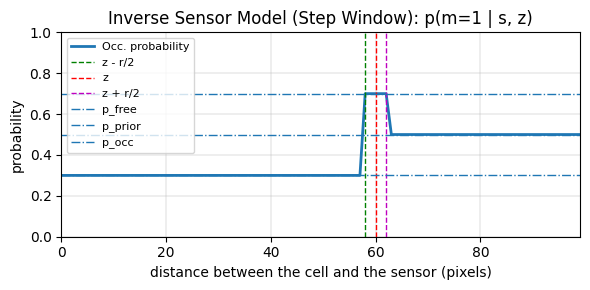

In [2]:
p = np.array([p_occ_step(si, z, r, P_FREE, P_PRIOR, P_OCC) for si in s])

plt.figure(figsize=(6, 3))
plt.plot(s, p, linewidth=2, label="Occ. probability")

plt.axvline(z - r/2.0, linestyle="--", color='g', linewidth=1, label="z - r/2")
plt.axvline(z, linestyle="--", color='r', linewidth=1, label="z")
plt.axvline(z + r/2.0, color='m', linestyle="--", linewidth=1, label="z + r/2")

plt.axhline(P_FREE, linestyle="-.", linewidth=1, label="p_free")
plt.axhline(P_PRIOR, linestyle="-.", linewidth=1, label="p_prior")
plt.axhline(P_OCC, linestyle="-.", linewidth=1, label="p_occ")

plt.title("Inverse Sensor Model (Step Window): p(m=1 | s, z)")
plt.xlabel("distance between the cell and the sensor (pixels)")
plt.ylabel("probability")
plt.ylim(0.0, 1.0); plt.xlim(0, s[-1])
plt.legend(loc="upper left", fontsize=8); plt.grid(True, linewidth=0.3)
plt.tight_layout(); plt.show()



---

##### 🕹️ `Python Example #1: Interactive Occupancy Grid Mapping`

Move the mouse over the <span style="color:#ffa500">**floor plan**</span> (left). A single rotating LiDAR <span style="color:#ffa500">**beam**</span> casts rays from the mouse pose and updates the <span style="color:#ffa500">**occupancy grid**</span> (right) using a <span style="color:#ffa500">**step-window inverse sensor model**</span>:
- cells <span style="color:#ffa500">**before**</span> the measured hit window → pushed toward <span style="color:#ffa500">**free**,
- cells <span style="color:#ffa500">**inside**</span> the window $[z-\tfrac{r}{2},\, z+\tfrac{r}{2}]$ → pushed toward <span style="color:#ffa500">**occupied**</span>,
- cells <span style="color:#ffa500">**beyond**</span> the window → left at the <span style="color:#ffa500">**prior**</span> (no update).

Press <span style="color:#ffa500">**S**</span> to save the map, or <span style="color:#ffa500">**R**</span> to reset the map.

In [4]:
import pygame
import sys
import os
import time
import numpy as np
from math import cos, sin, atan2, pi

# --- Parameters ---
# --- Beam / scanner ---
MAX_RANGE   = 200               # [pixels]
BEAM_SPEED  = 2 * pi * 10       # [rad/s] 10 rev/s
beam_angle  = 0.0               # current beam angle [rad]

# Measurement noise: [range_px, bearing_rad]
NOISE_STD = [1.0, np.deg2rad(0.5)]

# Inverse sensor model (step window) parameters
P0        = 0.5                 # prior occupancy
P_FREE    = 0.3                 # free-space evidence (< 0.5)
P_HIT     = 0.7                 # occupied evidence   (> 0.5)

# Window width (in *cells*) around the measured hit: [z - R_HALF, z + R_HALF]
R_WINDOW_CELLS = 2              # typical: 1-3 cells

# Log-odds clamping
LO_MAX    = 4.0                 # clamp to [-LO_MAX, LO_MAX]

# Grid resolution (pixels per cell) — change to coarsen/refine the map
CELL_SIZE = 4

# --- Helper functions ---
def logit(p: float, eps=1e-6) -> float:
    """Logit function with clipping to avoid inf/-inf.
    Args:
        p (float): probability in [0, 1]
        eps (float): small value to avoid log(0)
    Returns:
        float: log-odds value
    """
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def logistic(l: float) -> float:
    """Logistic function (inverse of logit).
    Args:
        l (float): log-odds value
    Returns:
        float: probability in [0, 1]
    """
    return 1.0 / (1.0 + np.exp(-l))

# --- Pygame init ---
pygame.init()

# Load & scale floor plan (black = obstacle, white = free)
FLOOR_PLAN_PATH = '../figures/floor_plan.png'
FLOOR_DIR = os.path.dirname(FLOOR_PLAN_PATH) or '.'

floor_plan_orig = pygame.image.load(FLOOR_PLAN_PATH)
w_orig, h_orig = floor_plan_orig.get_size()
max_w, max_h = 500, 400
scale = min(max_w / w_orig, max_h / h_orig)
w, h = int(w_orig * scale), int(h_orig * scale)
floor_plan = pygame.transform.smoothscale(floor_plan_orig, (w, h))

# Build "ground-truth" wall mask from the image
arr = pygame.surfarray.array3d(floor_plan)      # shape (w, h, 3)
wall_mask = np.all(arr < 128, axis=2)           # black ~ obstacle

# Screen: two panels side-by-side
screen = pygame.display.set_mode((w*2, h))
pygame.display.set_caption("Occupancy Grid Mapping (step-window inverse model)")
clock = pygame.time.Clock()

# --- Occupancy grid ---
GW = (w + CELL_SIZE - 1) // CELL_SIZE
GH = (h + CELL_SIZE - 1) // CELL_SIZE

# Window half-width in *pixels*
R_WINDOW = R_WINDOW_CELLS * CELL_SIZE
R_HALF   = R_WINDOW / 2.0

# Prior log-odds
L0 = logit(P0)

# Log-odds grid initialized to prior
logodds = np.full((GW, GH), L0, dtype=np.float32)

# --- Ray casting (for display) ---
def cast_beam(pos_xy: np.ndarray, angle: float, max_r: float, noise_std: float = 0.0) -> tuple:
    """Cast a ray from the given position in the specified direction.
    Args:
        pos_xy (np.ndarray): (x, y) position of the ray origin
        angle (float): angle of the ray in radians
        max_r (float): maximum range of the ray
        noise_std (float): standard deviation of Gaussian noise to add to the measured range
    Returns:
        tuple: (hit_xy, measured_range) where hit_xy is the (x, y) of the hit or None if no hit,
               and measured_range is the distance to the hit (with noise if specified)
    """
    x0, y0 = pos_xy
    for d in range(int(max_r)):
        x = int(x0 + d * cos(angle))
        y = int(y0 + d * sin(angle))
        if x < 0 or x >= w or y < 0 or y >= h:
            return None, float(d)
        if wall_mask[x, y]:
            return (x, y), float(d + np.random.normal(0, noise_std))
    return None, float(max_r)

# --- Grid helpers (indexing/drawing) ---
def pix_to_cell(x: int, y: int) -> tuple:
    """Convert pixel coordinates to grid cell indices.
    Args:
        x (int): x coordinate in pixels
        y (int): y coordinate in pixels
    Returns:
        tuple: (gx, gy) grid cell indices
    """
    return x // CELL_SIZE, y // CELL_SIZE

def draw_grid_map(surface: pygame.Surface, grid_logodds: np.ndarray, cell_size: int, offset=(0, 0)):
    """Draw the occupancy grid on the given surface.
    Args:
        surface (pygame.Surface): surface to draw on
        grid_logodds (np.ndarray): grid of log-odds values
        cell_size (int): size of each cell in pixels
        offset (tuple): (x, y) offset to draw the grid at
    """
    ox, oy = offset
    p = logistic(grid_logodds)
    gray = (255.0 * (1.0 - p)).astype(np.uint8)  # occupied -> dark
    for gx in range(GW):
        for gy in range(GH):
            g = int(gray[gx, gy])
            rect = pygame.Rect(ox + gx*cell_size, oy + gy*cell_size, cell_size, cell_size)
            pygame.draw.rect(surface, (g, g, g), rect)

def save_occupancy_png():
    """Save current occupancy grid as PNG in the same folder as the floor plan."""
    surf = pygame.Surface((w, h))
    surf.fill((0, 0, 0))
    draw_grid_map(surf, logodds, CELL_SIZE, offset=(0, 0))
    ts = time.strftime("%Y%m%d_%H%M%S")
    out_path = os.path.join(FLOOR_DIR, f"occupancy_map_{ts}.png")
    pygame.image.save(surf, out_path)
    print(f"[info] Saved occupancy map to: {out_path}")

# --- Inverse Sensor Model (step window) ---
def p_occ_beam(r: float, z: float, hit_exists: bool) -> float:
    """Inverse sensor model for a single beam with step window.
    Args:
        r (float): distance from the sensor to the cell
        z (float): measured range
        hit_exists (bool): whether a hit was detected
    Returns:
        float: probability that the cell is occupied
    """
    if not hit_exists:
        return P_FREE if r < z else P0
    if r < z - R_HALF:
        return P_FREE
    elif r <= z + R_HALF:
        return P_HIT
    else:
        return P0

# --- Apply one beam update to the grid ---
def update_grid_from_measurement(robot_xy: np.ndarray, angle_meas: float, z_meas: float, hit_exists: bool):
    """Update the occupancy grid from a single range measurement.
    Args:
        robot_xy (np.ndarray): (x, y) position of the robot in pixels
        angle_meas (float): bearing of the measurement in radians
        z_meas (float): measured range in pixels
        hit_exists (bool): whether a hit was detected
    """
    r_end = int(min(z_meas + (R_HALF if hit_exists else 0.0), MAX_RANGE))
    updated = set()
    for r in range(max(0, r_end)):
        x = int(robot_xy[0] + r * cos(angle_meas))
        y = int(robot_xy[1] + r * sin(angle_meas))
        if x < 0 or x >= w or y < 0 or y >= h:
            break
        gx, gy = pix_to_cell(x, y)
        key = (gx, gy)
        if key in updated:
            continue
        updated.add(key)
        p = p_occ_beam(r, z_meas, hit_exists)
        if abs(p - P0) < 1e-6:
            continue
        dL = logit(p) - L0
        logodds[gx, gy] = np.clip(logodds[gx, gy] + dL, -LO_MAX, LO_MAX)

# --- Main loop ---
running = True
while running:
    dt = clock.tick(60) / 1000.0
    beam_angle = (beam_angle + BEAM_SPEED * dt) % (2 * pi)

    for ev in pygame.event.get():
        if ev.type == pygame.QUIT:
            running = False
        elif ev.type == pygame.KEYDOWN:
            if ev.key == pygame.K_r:
                logodds[:, :] = L0  # reset map
            elif ev.key == pygame.K_s:
                save_occupancy_png()  # <-- SAVE with 'S'

    # Panels background
    screen.fill((50, 50, 50))

    # Left panel: floor plan + rotating beam + robot marker
    screen.blit(floor_plan, (0, 0))
    mouse = np.array(pygame.mouse.get_pos(), dtype=float)
    mouse[0] = np.clip(mouse[0], 0, w - 1)
    mouse[1] = np.clip(mouse[1], 0, h - 1)
    pygame.draw.circle(screen, (0, 0, 255), mouse.astype(int), 5)

    # Cast a beam against the ground-truth image for visualization (not used in update)
    hit, dist_noisy = cast_beam(mouse, beam_angle, MAX_RANGE, NOISE_STD[0])
    if hit is not None:
        hx, hy = hit
        true_bearing = atan2(hy - mouse[1], hx - mouse[0])
        noisy_bearing = true_bearing + np.random.normal(0, NOISE_STD[1])
        pygame.draw.line(screen, (255, 0, 0), mouse.astype(int), (hx, hy), 2)
        update_grid_from_measurement(mouse, noisy_bearing, dist_noisy, hit_exists=True)
    else:
        noisy_bearing = beam_angle + np.random.normal(0, NOISE_STD[1])
        update_grid_from_measurement(mouse, noisy_bearing, dist_noisy, hit_exists=False)

    # Right panel: render occupancy grid
    pygame.draw.rect(screen, (0, 0, 0), (w, 0, w, h))
    draw_grid_map(screen, logodds, CELL_SIZE, offset=(w, 0))

    # Also draw robot dot on the occupancy panel for reference
    pygame.draw.circle(screen, (0, 128, 255), (int(w + mouse[0]), int(mouse[1])), 4)

    pygame.display.flip()

pygame.quit()
sys.exit()


SystemExit: 


Parameters to try changing (and what happens):

- `CELL_SIZE:` grid resolution (pixels per cell). Smaller = finer map (more detail, more compute). Larger = coarser, faster, thicker walls.

- `R_WINDOW_CELLS:` hit window width (in cells). 1–3 is typical. Larger windows thicken walls; too small may cause gaps.

- `P_FREE, P_HIT, P0:` step probabilities. Lower `P_FREE` carves stronger free-space; higher `P_HIT` makes obstacles more certain; `P0` is the neutral prior (usually 0.5).

- `LO_MAX:` log-odds clamp. Limits saturation; smaller values make the map forget faster when evidence changes.

- `NOISE_STD = [range_px, bearing_rad]:` measurement noise. Increase to see how noise widens/roughens walls and free corridors.

- `MAX_RANGE:` sensor range (pixels). Shorter range reduces updates; longer range covers more area per revolution.

- `BEAM_SPEED:` rotation speed (rad/s). Faster rotation fills the map sooner but can look flickery on screen.

---



#### ✔️ <span style="color:#a4d4a3">Occupancy Grid Map — Summary</span>

- Occupancy grid maps discretize the space into <span style="color:#ffa500">**independent cells**</span>.  

- Each cell is a <span style="color:#ffa500">**binary random variable**</span> estimating if the cell is occupied.  

- <span style="color:#ffa500">**Static-state binary Bayes filter**</span> per cell.  

- Mapping with <span style="color:#ffa500">**known poses**</span> is easy.  

- <span style="color:#ffa500">**Log-odds**</span> model is fast to compute.  

- No need for predefined features.

---



### 📐 <span style="color:#a4d4a3">**Incremental Scan Alignment** (Extra)</span>

If we try to make an occupancy map using only the <span style="color:#ffa500">**raw odometry**</span> the results is not very good.

- Motion is <span style="color:#ffa500">**noisy**</span>; we cannot ignore it.  
- Assuming <span style="color:#ffa500">**known poses**</span> fails!  
- Often, the <span style="color:#ffa500">**sensor is rather precise**</span>.  
- <span style="color:#ffa500">**Scan-matching**</span> tries to incrementally align two scans or a map to a scan, <span style="color:#ffa500">**without revisiting the past/map**</span>.

#### <span style="color:#a4d4a3">**Pose correction using scan matching**</span> (MAP)

Maximize the likelihood of the <span style="color:#ffa500">**current pose**</span> relative to the <span style="color:#ffa500">**previous pose**</span> and the <span style="color:#ffa500">**map**</span> constructed so far:

$$
x_t^\star = \arg\max_{x_t} \{ \; p(z_t \mid x_t, m_{t-1}) \; p(x_t \mid u_{t-1}, x_{t-1}^\star) \; \},
$$

where:

- $z_t$ is the current measurement.
- $m_{t-1}$ is the map constructed so far.
- $u_{t-1}$ is the robot motion.

<span style="color:#a4d4a3">**Various different ways to realize scan matching:**</span>

- Iterative Closest Point (<span style="color:#00703c">**ICP**</span>)
- <span style="color:#00703c">**Scan-to-scan**</span>
- <span style="color:#00703c">**Scan-to-map**</span>
- <span style="color:#00703c">**Map-to-map**</span>
- <span style="color:#00703c">**Feature-based**</span>
- <span style="color:#00703c">**RANSAC**</span> for outlier rejection
- Correlative matching

---


### 📚 <span style="color:#a4d4a3">**Reading Material**</span>

**Static State Binary Bayes Filter**
- Thrun et al.: *"Probabilistic Robotics"*, **Chapter 4.2**

**Occupancy Grid Mapping**
- Thrun et al.: *"Probabilistic Robotics"*, **Chapter 9.1-9.2**
